# Neural Collaborative Filtering
Source: [Machine Learning Notebook](https://calvinfeng.gitbook.io/machine-learning-notebook/supervised-learning/recommender/neural_collaborative_filtering)

## Embeddings
입력으로 사용할 랜덤 벡터 생성

In [1]:
from keras.utils.np_utils import to_categorical

# We have 10 users, each is uniquely identified by an ID.
users = [i for i in range(10)]
to_categorical(users)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [2]:
import numpy as np

latent_dim = 5
inputs = to_categorical(users)
embed_mat = np.random.randn(len(users), latent_dim)

inputs.dot(embed_mat)

array([[-0.03998624,  1.89462522, -1.77154768, -0.02175692, -0.80181288],
       [-0.92079006,  0.80010476,  0.03583286, -0.11919101,  0.09510611],
       [ 1.84676948,  0.61956981,  2.0534701 ,  1.02920107, -1.80525553],
       [ 0.89586295,  0.21419802, -0.24730693,  1.78575229, -1.51880377],
       [ 0.43853648, -0.96270236, -0.23864376, -0.88646744, -0.96688383],
       [-2.17594376, -0.67135155,  0.05804322, -1.08234053, -0.51814278],
       [ 0.28151864,  0.00574806,  1.36042808,  1.63968942,  0.09955352],
       [-0.09340488,  0.4411615 , -1.19678279, -0.88338213, -0.55518667],
       [-1.59131797, -1.3759279 ,  1.23434906, -0.06196899, -0.16117362],
       [-0.1618546 ,  0.95957111,  1.65609081,  0.2249455 , -1.21034848]])

## Dataset: Movie Ratings
MovieLens 100k movie ratings 데이터 사용

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('ratings.csv', header=0, names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Need to map movie ID to [1, num_movies]
movie_id_to_new_id = dict()
id = 1
for index, row in dataset.iterrows():
    if movie_id_to_new_id.get(row['movie_id']) is None:
        movie_id_to_new_id[row['movie_id']] = id
        dataset.at[index, 'movie_id'] = id
        id += 1
    else:
        dataset.at[index, 'movie_id'] = movie_id_to_new_id.get(row['movie_id'])

num_users = len(dataset.user_id.unique())
num_movies = len(dataset.movie_id.unique())
train, test = train_test_split(dataset, test_size=0.2)

print('Number of movies', num_movies)
print('Number of users', num_users)

Number of movies 9724
Number of users 610


In [4]:
train.head()

,user_id,movie_id,rating,timestamp
90672,590,74,4.5,1258420427
9786,64,1817,2.5,1161559578
69298,448,442,4.0,1019127998
94366,599,9079,3.0,1519127698
44041,294,662,2.0,966597672


In [5]:
test.head()

,user_id,movie_id,rating,timestamp
88777,573,171,5.0,1186722658
97154,605,21,3.0,1277097509
23742,163,3285,3.0,894217532
71262,456,1402,3.0,856883540
97172,605,701,3.0,1277175862


## Generalized Matrix Factorization (GMF)

$\hat y_{ui} = a \left ( h^T (p_u \cdot q_i) \right )$

- $a$: activation function
- $h$: edge weight matrix of the output layer

### Matrix Factorization
activation function 및 추가적인 weight를 따로 사용하지 않은 classic matrix factorization임

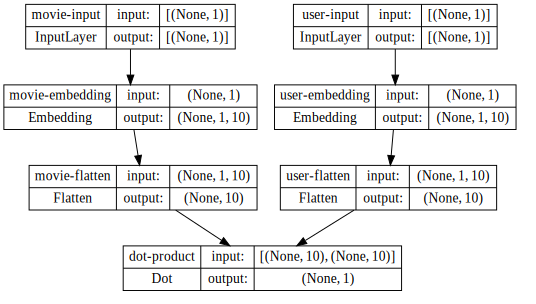

In [6]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, Dot
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

# Let's use a higher latent dimension.
latent_dim = 10

movie_input = Input(shape=[1],name='movie-input')
movie_embedding = Embedding(num_movies + 1, latent_dim, name='movie-embedding')(movie_input)
movie_vec = Flatten(name='movie-flatten')(movie_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

prod = Dot(axes=1, name='dot-product')([movie_vec, user_vec])

model = Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

# Adjust DPI to reduce SVG size
dot = model_to_dot(model, show_shapes=True, dpi=70)

# Create SVG with adjusted size
svg = SVG(dot.create(prog='dot', format='svg'))

display(svg)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie-input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie-embedding (Embedding)    (None, 1, 10)        97250       ['movie-input[0][0]']            
                                                                                                  
 user-embedding (Embedding)     (None, 1, 10)        6110        ['user-input[0][0]']             
                                                                                              

Epoch 1/10
2521/2521 [==============================] - 6s 2ms/step - loss: 10.9756
Epoch 2/10
2521/2521 [==============================] - 5s 2ms/step - loss: 3.5360
Epoch 3/10
2521/2521 [==============================] - 5s 2ms/step - loss: 1.8739
Epoch 4/10
2521/2521 [==============================] - 5s 2ms/step - loss: 1.3235
Epoch 5/10
2521/2521 [==============================] - 5s 2ms/step - loss: 1.0691
Epoch 6/10
2521/2521 [==============================] - 5s 2ms/step - loss: 0.9313
Epoch 7/10
2521/2521 [==============================] - 5s 2ms/step - loss: 0.8480
Epoch 8/10
2521/2521 [==============================] - 5s 2ms/step - loss: 0.7919
Epoch 9/10
2521/2521 [==============================] - 5s 2ms/step - loss: 0.7513
Epoch 10/10
2521/2521 [==============================] - 5s 2ms/step - loss: 0.7206


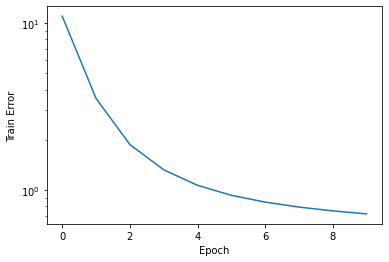

631/631 [==============================] - 1s 2ms/step


0.78625644610911

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

history = model.fit([train.user_id, train.movie_id], train.rating, epochs=10)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

다음과 같이 `non-negativity`를 추가할 수도 있음

In [9]:
from keras.constraints import non_neg

latent_dim = 5

movie_input = Input(shape=[1],name='movie-input')
movie_embedding = Embedding(num_movies + 1, latent_dim, name='movie-embedding',
                                                        embeddings_constraint=non_neg())(movie_input)
movie_vec = Flatten(name='movie-flatten')(movie_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding',
                                                      embeddings_constraint=non_neg())(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

prod = Dot(axes=1, name='dot-product')([movie_vec, user_vec])

model = Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

### Neural Network with MF
non-linearity 추가

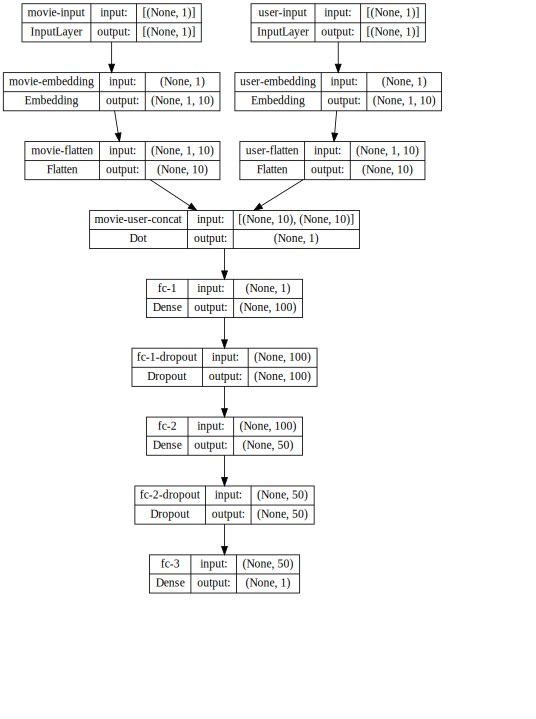

In [10]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, Dot, Dropout, Dense
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

latent_dim = 10

movie_input = Input(shape=[1],name='movie-input')
movie_embedding = Embedding(num_movies + 1, latent_dim, name='movie-embedding')(movie_input)
movie_vec = Flatten(name='movie-flatten')(movie_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

concat = Dot(axes=1, name='movie-user-concat')([movie_vec, user_vec])
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat)
fc_1_dropout = Dropout(0.2, name='fc-1-dropout')(fc_1)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_dropout = Dropout(0.2, name='fc-2-dropout')(fc_2)
fc_3 = Dense(1, name='fc-3', activation='relu')(fc_2_dropout)


model = Model([user_input, movie_input], fc_3)
model.compile(optimizer=Adam(learning_rate=0.1), loss='mean_squared_error')

#SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Adjust DPI to reduce SVG size
dot = model_to_dot(model, show_shapes=True, dpi=60)

# Create SVG with adjusted size
svg = SVG(dot.create(prog='dot', format='svg'))

display(svg)

In [11]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie-input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie-embedding (Embedding)    (None, 1, 10)        97250       ['movie-input[0][0]']            
                                                                                                  
 user-embedding (Embedding)     (None, 1, 10)        6110        ['user-input[0][0]']             
                                                                                            

Epoch 1/10
2521/2521 [==============================] - 9s 3ms/step - loss: 1.5014
Epoch 2/10
2521/2521 [==============================] - 7s 3ms/step - loss: 1.0956
Epoch 3/10
2521/2521 [==============================] - 7s 3ms/step - loss: 1.1290
Epoch 4/10
2521/2521 [==============================] - 8s 3ms/step - loss: 1.1129
Epoch 5/10
2521/2521 [==============================] - 7s 3ms/step - loss: 1.0967
Epoch 6/10
2521/2521 [==============================] - 7s 3ms/step - loss: 5.7057
Epoch 7/10
2521/2521 [==============================] - 7s 3ms/step - loss: 36.9058
Epoch 8/10
2521/2521 [==============================] - 7s 3ms/step - loss: 1.0865
Epoch 9/10
2521/2521 [==============================] - 8s 3ms/step - loss: 1.0921
Epoch 10/10
2521/2521 [==============================] - 7s 3ms/step - loss: 1.0936


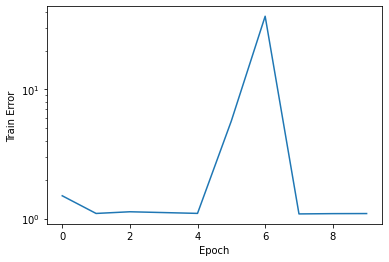

631/631 [==============================] - 1s 2ms/step


0.8494198559674419

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

history = model.fit([train.user_id, train.movie_id], train.rating, epochs=10)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

## Multi-Layer Perceptron
위 GMF를 one-layer MLP와 결합함

$\hat y_{ui} = \sigma \left ( h^T a \left ( p_u \cdot q_u + W \begin{bmatrix} p_u \\ q_u \end{bmatrix} + b \right ) \right )$

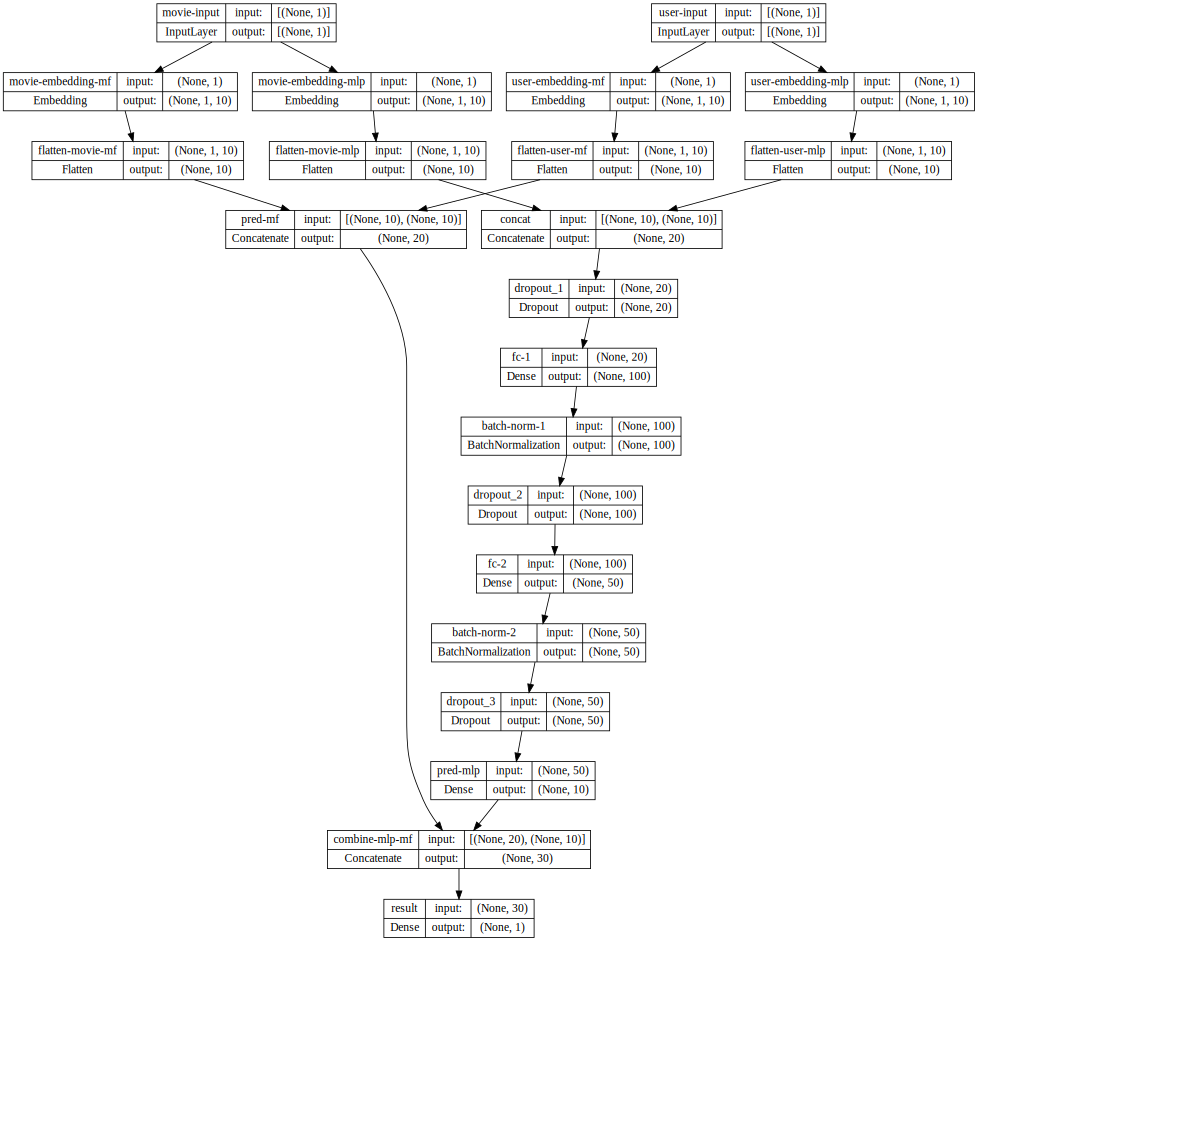

In [13]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, concatenate, Dropout, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

latent_dim = 10

# Define inputs
movie_input = Input(shape=[1],name='movie-input')
user_input = Input(shape=[1], name='user-input')

# MLP Embeddings
movie_embedding_mlp = Embedding(num_movies + 1, latent_dim, name='movie-embedding-mlp')(movie_input)
movie_vec_mlp = Flatten(name='flatten-movie-mlp')(movie_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF Embeddings
movie_embedding_mf = Embedding(num_movies + 1, latent_dim, name='movie-embedding-mf')(movie_input)
movie_vec_mf = Flatten(name='flatten-movie-mf')(movie_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

# MLP layers
concat = concatenate([movie_vec_mlp, user_vec_mlp], name='concat')
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
pred_mf = concatenate([movie_vec_mf, user_vec_mf], name='pred-mf')
combine_mlp_mf = concatenate([pred_mf, pred_mlp], name='combine-mlp-mf')

# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([user_input, movie_input], result)
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_absolute_error')

#SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Adjust DPI to reduce SVG size
dot = model_to_dot(model, show_shapes=True, dpi=60)

# Create SVG with adjusted size
svg = SVG(dot.create(prog='dot', format='svg'))

display(svg)

In [14]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie-input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie-embedding-mlp (Embedding  (None, 1, 10)       97250       ['movie-input[0][0]']            
 )                                                                                                
                                                                                                  
 user-embedding-mlp (Embedding)  (None, 1, 10)       6110        ['user-input[0][0]']       

Epoch 1/10
2521/2521 [==============================] - 10s 3ms/step - loss: 0.7421
Epoch 2/10
2521/2521 [==============================] - 8s 3ms/step - loss: 0.6582
Epoch 3/10
2521/2521 [==============================] - 8s 3ms/step - loss: 0.6411
Epoch 4/10
2521/2521 [==============================] - 8s 3ms/step - loss: 0.6340
Epoch 5/10
2521/2521 [==============================] - 8s 3ms/step - loss: 0.6257
Epoch 6/10
2521/2521 [==============================] - 8s 3ms/step - loss: 0.6214
Epoch 7/10
2521/2521 [==============================] - 8s 3ms/step - loss: 0.6176
Epoch 8/10
2521/2521 [==============================] - 8s 3ms/step - loss: 0.6159
Epoch 9/10
2521/2521 [==============================] - 8s 3ms/step - loss: 0.6130
Epoch 10/10
2521/2521 [==============================] - 8s 3ms/step - loss: 0.6113


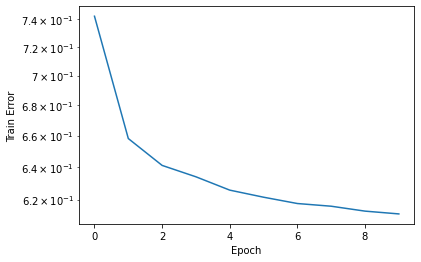

631/631 [==============================] - 1s 1ms/step


0.6852018062788358

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

history = model.fit([train.user_id, train.movie_id], train.rating, epochs=10)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)